<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Packages" data-toc-modified-id="Packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Packages</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Model-specification" data-toc-modified-id="Model-specification-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Model specification</a></span></li><li><span><a href="#Update-priors" data-toc-modified-id="Update-priors-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Update priors</a></span></li></ul></li></ul></div>

# Introduction

This notebook reproduces section 4.3 A Gaussian model of height.

The task is to model height assuming height follows a normal distribution.

# Packages

In [1]:
using Query
using HTTP
using CSV
using DataFrames

In [2]:
using StatsPlots

In [3]:
using Distributions
using StatsBase

In [4]:
using RCall


R version 3.6.2 (2019-12-12) -- "Dark and Stormy Night"
Copyright (C) 2019 The R Foundation for Statistical Computing
Platform: x86_64-w64-mingw32/x64 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.



# Data

Download the `Howell1` dataset:

In [5]:
file_url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv"
d = HTTP.get(file_url).body |> IOBuffer |> CSV.read
first(d, 5)

,height,weight,age,male
,Float64,Float64,Float64,Int64
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


We want only the adult heights:

In [6]:
adults = @from i in d begin
    @where i.age >= 18
    @select {i.height}
    @collect DataFrame
end

first(adults, 5)

,height
,Float64
1,151.765
2,139.7
3,136.525
4,156.845
5,145.415


# Model

## Model specification

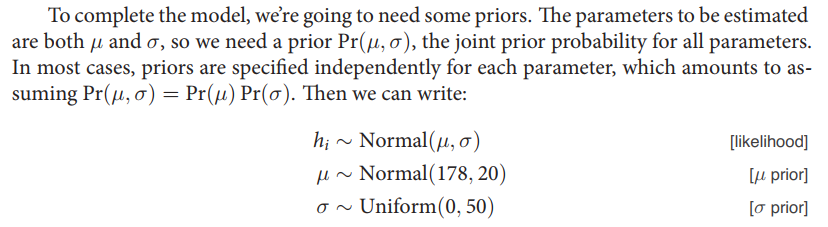

Visualize  the priors:

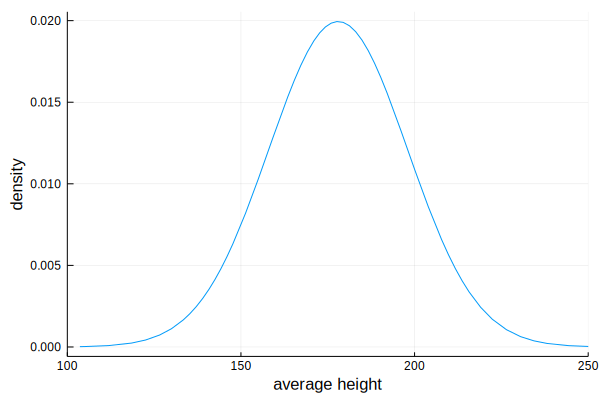

In [7]:
plot(Normal(178, 20), legend=false, xlims=(100, 250), xlabel="average height", ylabel="density")

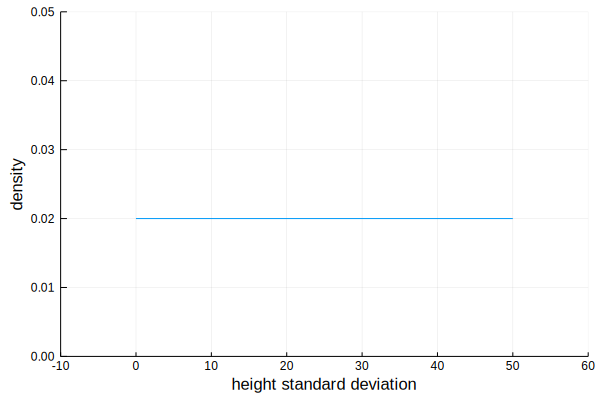

In [8]:
plot(Uniform(0, 50), 
    legend=false, 
    xlims=(-10, 60), 
    xlabel="height standard deviation",
    ylims=(0, 5e-2),
    ylabel="density")

Visualize the distribution of an individual height based on the priors:

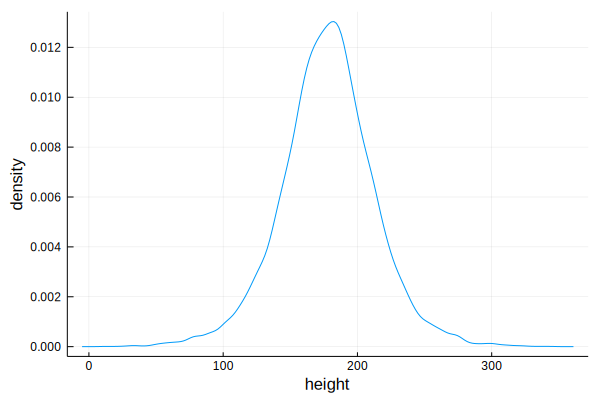

In [9]:
prior_mean = Normal(178, 20)
prior_stdev = Uniform(0, 50)
trials = Int(1e4)

means = rand(prior_mean, trials)
stdevs = rand(prior_stdev, trials)

sample_height(mean::Float64, stdev::Float64) = Normal(mean, stdev) |> rand

prior_heights = sample_height.(means, stdevs)

density(prior_heights, legend=false, xlabel="height", ylabel="density")

## Update priors

We will update the priors to get the posterior distribution usign grid approximation.

Define some utility functions:

In [10]:
"""
Compute the log likelihood of the data given a hypothesis 
"""
ll_data(mean, stdev) = begin
    data = adults.height
    d = Normal(mean, stdev)
    # hint: product of probabilities is sum of log probabilities
    pdf.(d, data) .|> log |> sum
end

"""
Compute the log of the probability of observing `value` given a distribution `d`
"""
l_param(value::Float64, d::Distribution) = pdf(d, value) |> log

"""
Compute the log of the joint probability of a sampled prior (hypothesis)
"""
l_joint_prior(mean, stdev) = l_param(mean, prior_mean) + l_param(stdev, prior_stdev)
;

First, we create a grid containing all possible combinations of the parameters of the height model i.e. $\mu$ and $\sigma$:

In [11]:
means = range(140, 160, length=200)
stdevs = range(4, 9, length=200)

params = Iterators.product(means, stdevs) |> collect
params[1:10]

10-element Array{Tuple{Float64,Float64},1}:
 (140.0, 4.0)             
 (140.10050251256283, 4.0)
 (140.20100502512562, 4.0)
 (140.30150753768845, 4.0)
 (140.40201005025125, 4.0)
 (140.50251256281408, 4.0)
 (140.60301507537687, 4.0)
 (140.7035175879397, 4.0) 
 (140.80402010050253, 4.0)
 (140.90452261306532, 4.0)

In [12]:
params

200×200 Array{Tuple{Float64,Float64},2}:
 (140.0, 4.0)    (140.0, 4.02513)    …  (140.0, 8.97487)    (140.0, 9.0)  
 (140.101, 4.0)  (140.101, 4.02513)     (140.101, 8.97487)  (140.101, 9.0)
 (140.201, 4.0)  (140.201, 4.02513)     (140.201, 8.97487)  (140.201, 9.0)
 (140.302, 4.0)  (140.302, 4.02513)     (140.302, 8.97487)  (140.302, 9.0)
 (140.402, 4.0)  (140.402, 4.02513)     (140.402, 8.97487)  (140.402, 9.0)
 (140.503, 4.0)  (140.503, 4.02513)  …  (140.503, 8.97487)  (140.503, 9.0)
 (140.603, 4.0)  (140.603, 4.02513)     (140.603, 8.97487)  (140.603, 9.0)
 (140.704, 4.0)  (140.704, 4.02513)     (140.704, 8.97487)  (140.704, 9.0)
 (140.804, 4.0)  (140.804, 4.02513)     (140.804, 8.97487)  (140.804, 9.0)
 (140.905, 4.0)  (140.905, 4.02513)     (140.905, 8.97487)  (140.905, 9.0)
 (141.005, 4.0)  (141.005, 4.02513)  …  (141.005, 8.97487)  (141.005, 9.0)
 (141.106, 4.0)  (141.106, 4.02513)     (141.106, 8.97487)  (141.106, 9.0)
 (141.206, 4.0)  (141.206, 4.02513)     (141.206, 8.97487) 

For each pair of params, we compute the numerator in the bayes formula:

In [13]:
bayes_num = map(params) do (mean, stdev)
    ll_data(mean, stdev) + l_joint_prior(mean, stdev)
end 

bayes_num[1:10]

10-element Array{Float64,1}:
 -3822.4074484306843
 -3790.2340429800583
 -3758.2828793920235
 -3726.5539576665587
 -3695.047277803681 
 -3663.7628398033744
 -3632.700643665655 
 -3601.8606893905076
 -3571.2429769779383
 -3540.847506427958 

Apply the normalizing constant.

We can't actually apply the normalizing constant as defined in bayes formula because converting the log likelihoods to probabilities gives:

In [14]:
exp.(bayes_num) |> sum

0.0

Instead, what we will do is normalize by the maximum probability.

hint:
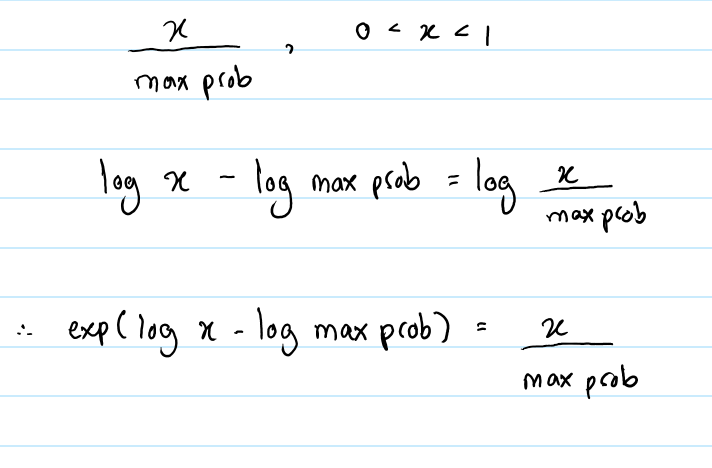

In [15]:
max_ll = maximum(bayes_num)

params_prob = (bayes_num .- max_ll) .|> exp
;

Visualize the posterior distribution:

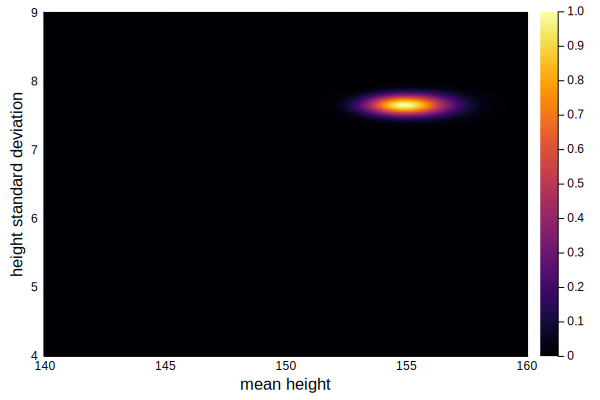

In [16]:
xs = params[:,1] .|> first 
ys = params[1, :] .|> last

heatmap(xs, ys, params_prob, xlabel="mean height", ylabel="height standard deviation")

Visualize some **samples** from the posterior:

In [17]:
n = Int(1e4)
posterior_samples = sample(params, weights(params_prob), n, replace=true)
scatter(posterior_samples,  
        legend=false, 
        xlabel="sample mean", 
        ylabel="sample standard deviation",
        alpha=0.1)

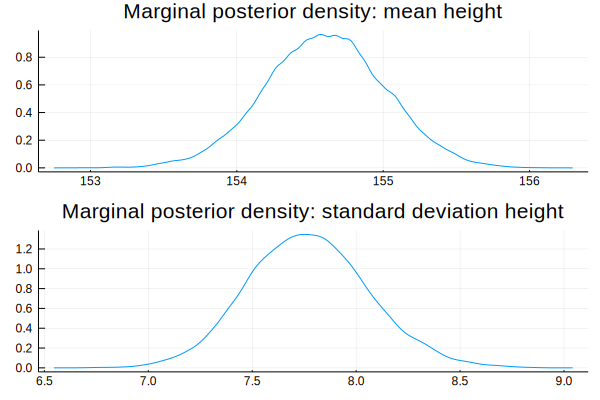

In [18]:
sample_means = posterior_samples .|> first
sample_stdevs = posterior_samples .|> last

p1 = density(sample_means, legend=false, title="Marginal posterior density: mean height")
p2 = density(sample_stdevs, legend=false, title="Marginal posterior density: standard deviation height")

plot(p1, p2, layout=(2, 1))

Note:

    These densities are very close to being normal distributions. And this is quite typical. As sample size increases, posterior densities approach the normal distribution.

Generate some heights from the posterior:

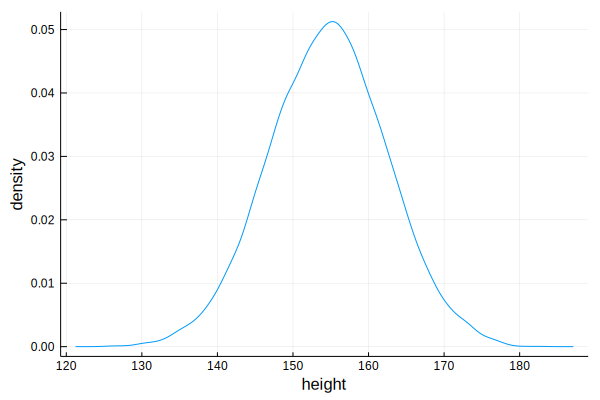

In [19]:
posterior_heights = sample_height.(sample_means, sample_stdevs)
density(posterior_heights, legend=false, xlabel="height", ylabel="density")

Check your posterior heights with real data:

In [20]:
describe(adults)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Nothing,DataType
1,height,154.597,136.525,154.305,179.07,,,Float64


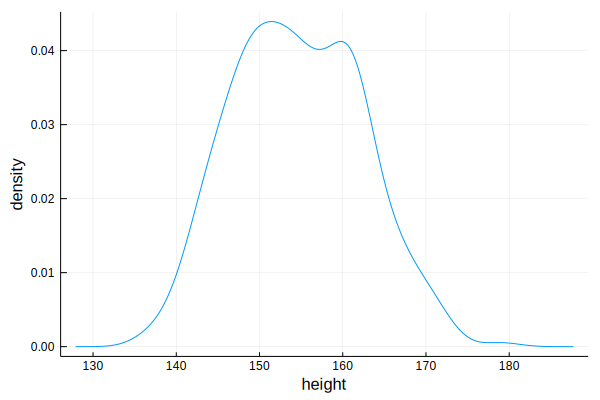

In [21]:
empirical_heights = adults[!,:height]
density(empirical_heights, legend=false, xlabel="height", ylabel="density")

Summarize the distributions using the 89% HPDI (Highest Posterior Density Interval):

In [22]:
R"rethinking::HPDI($(sample_means))"

RObject{RealSxp}
   |0.89    0.89| 
153.8693 155.1759 


In [23]:
R"rethinking::HPDI($(sample_stdevs))"

RObject{RealSxp}
   |0.89    0.89| 
7.291457 8.195980 


Plot the prior, posterior, and empirical heights together:

┌ Warning: RCall.jl: -- Attaching packages --------------------------------------- tidyverse 1.3.0 --
│ v ggplot2 3.2.1     v purrr   0.3.3
│ v tibble  2.1.3     v dplyr   0.8.3
│ v tidyr   1.0.0     v stringr 1.4.0
│ v readr   1.3.1     v forcats 0.4.0
│ -- Conflicts ------------------------------------------ tidyverse_conflicts() --
│ x dplyr::filter() masks stats::filter()
│ x dplyr::lag()    masks stats::lag()
└ @ RCall C:\Users\mshukri\.julia\packages\RCall\lAV2K\src\io.jl:113


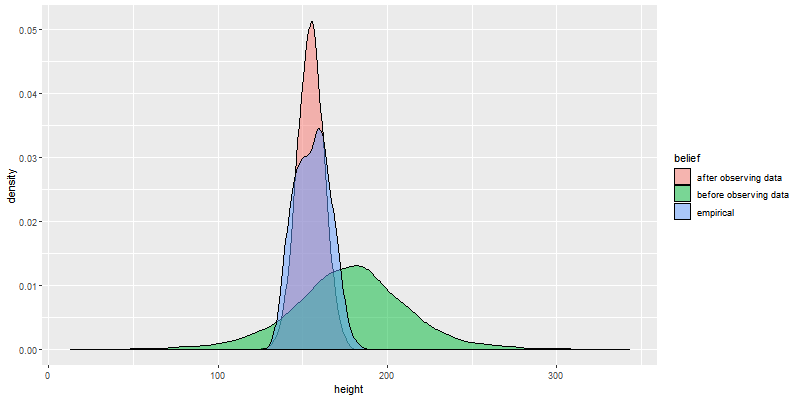

RObject{VecSxp}


In [24]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 800, :height => 400))

R"""
library(tidyverse)

empirical_heights = $(empirical_heights)
prior_heights = $(prior_heights)
posterior_heights =$(posterior_heights)


df <- tibble(height=empirical_heights, belief="empirical") %>%
  union(tibble(height=prior_heights, belief="before observing data")) %>%
  union(tibble(height=posterior_heights, belief="after observing data"))

ggplot(df, aes(x=height, fill=belief)) +
  geom_density(alpha=0.5)
"""